In [1]:
# Read ground truth file

ground_truth = []
ground_truth_file = "/mnt/c/Users/zhenh/tax_data/sampled_reads.label"
with open(ground_truth_file, 'r') as gt:
    for line in gt:
        ground_truth.append(int(line))

In [2]:
# Read GTDB metadata
import pandas as pd

gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')
species_set = set(gtdb_metadata["ncbi_species_taxid"])
len(species_set)

/tmp/ipykernel_22840/2040866023.py:4: DtypeWarning: Columns (61,63,65,74,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')


57939

In [14]:
# Read Kraken 2 output
kraken2_predictions = []

kraken2_output_file = "/mnt/c/Users/zhenh/tax_data/kraken2.output"

kraken2_predictions = pd.read_csv(kraken2_output_file, sep='\t', header=None)
kraken2_predictions.rename(columns={0: 'classified', 1: 'read_id', 2: 'classification_result', 3: 'read_length', 4: 'LCA'}, inplace=True)
kraken2_predictions.head()


,classified,read_id,classification_result,read_length,LCA
0,C,SRR24651298.1,100886,8663,100886:9 135858:2 100886:3 135858:8 0:28 13585...
1,C,SRR24651298.2,100886,2129,0:30 135858:2 100886:1 135858:12 0:25 100886:5...
2,C,SRR24651298.3,100886,3852,135858:37 100886:12 135858:2 100886:6 135858:3...
3,C,SRR24651298.4,100886,6186,100886:8 135858:12 0:47 100886:23 135858:2 100...
4,C,SRR24651298.5,100886,790,0:5 135858:4 100886:14 135858:1 100886:3 13585...


In [16]:
kraken2_predictions["ground_truth"] = ground_truth

## Unclassified reads

<Axes: xlabel='read_length', ylabel='Density'>

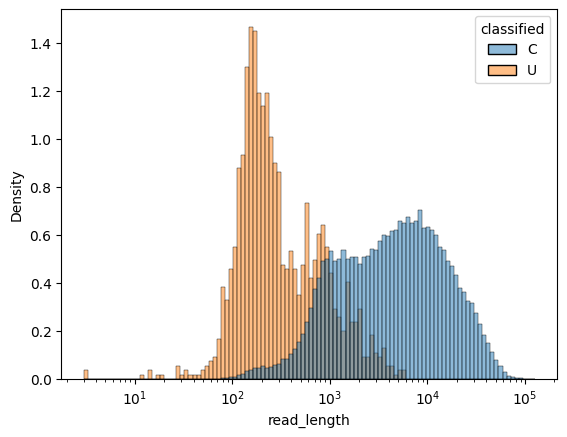

In [108]:
import seaborn as sns

sns.histplot(data=kraken2_predictions, x="read_length", hue="classified", log_scale=True, common_norm=False,
             stat="density")


In [48]:
from collections import Counter
from ete3 import NCBITaxa

ncbi = NCBITaxa()

def LCA_to_dict(LCA):
    res = Counter()
    for item in LCA.split(" "):
        tup = item.split(":")
        res[int(tup[0])] += int(tup[1])
    return res


def get_level(ID, level='genus'):
    """
    Find the genus of a given species ID.
    """
    if ID is None:
        return None
        
    # Get the lineage of the species
    try:
        lineage = ncbi.get_lineage(int(ID))
        ranks = ncbi.get_rank(lineage)
    except:
        return None

    #print(ranks)
    for i in ranks:
        if ranks[i] == level:
            return i
        
    return None


def check_LCA(LCA, ground_truth, level='genus'):
    prediction = LCA_to_dict(LCA)
    acceptable_prediction = 0
    for species in prediction:
        if species != 0:
            if get_level(ground_truth, level) == get_level(species, level):
                acceptable_prediction += prediction[species]
    return acceptable_prediction

def num_unclassified(LCA):
    prediction = LCA_to_dict(LCA)
    return prediction[0]


# Check for the unclassified reads, how many k-mer classification is actually acceptable
correct_classifications_genus = []
correct_classifications_species = []
unclassified_kmers = []
for i in range(len(kraken2_predictions)):
    correct_classifications_genus.append(check_LCA(kraken2_predictions["LCA"][i], kraken2_predictions["ground_truth"][i], 'genus'))
    correct_classifications_species.append(check_LCA(kraken2_predictions["LCA"][i], kraken2_predictions["ground_truth"][i], 'species'))
    unclassified_kmers.append(num_unclassified(kraken2_predictions["LCA"][i]))

kraken2_predictions["correct_at_genus"] = correct_classifications_genus
kraken2_predictions["correct_at_species"] = correct_classifications_species
kraken2_predictions["unclassified_kmers"] = unclassified_kmers

/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 558436 was translated into 838
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [50]:
classified = kraken2_predictions[kraken2_predictions["classified"] == 'C']
unclassified = kraken2_predictions[kraken2_predictions["classified"] == 'U']

len(unclassified) / len(kraken2_predictions)

0.018347222222222223

In [58]:
69 / len(unclassified)

0.052233156699470096

In [72]:
kraken2_predictions

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level
0,C,SRR24651298.1,100886,8663,100886:9 135858:2 100886:3 135858:8 0:28 13585...,100886,3148,2365,5051,True,True,True,True
1,C,SRR24651298.2,100886,2129,0:30 135858:2 100886:1 135858:12 0:25 100886:5...,100886,712,211,1356,True,True,True,True
2,C,SRR24651298.3,100886,3852,135858:37 100886:12 135858:2 100886:6 135858:3...,100886,1818,512,1992,True,True,True,True
3,C,SRR24651298.4,100886,6186,100886:8 135858:12 0:47 100886:23 135858:2 100...,100886,1616,638,4425,True,True,True,True
4,C,SRR24651298.5,100886,790,0:5 135858:4 100886:14 135858:1 100886:3 13585...,100886,355,115,396,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,C,SRR24651270.996,411464,25452,0:1 901:5 0:50 411464:5 901:1 0:3 901:5 0:23 4...,901,12662,11458,11170,True,True,True,True
71996,C,SRR24651270.997,411464,2122,411464:2 0:57 901:53 0:38 411464:5 901:1 41146...,901,541,534,1508,True,True,True,True
71997,C,SRR24651270.998,411464,11199,0:30 2479851:5 0:6 1930279:1 0:9 901:23 0:16 9...,901,2843,2803,7600,True,True,True,True
71998,C,SRR24651270.999,411464,2373,0:156 411464:3 0:20 411464:12 0:57 411464:11 1...,901,129,129,2192,True,True,True,True


In [74]:
kraken2_predictions[["read_length", "unclassified_kmers"]]

,read_length,unclassified_kmers
0,8663,5051
1,2129,1356
2,3852,1992
3,6186,4425
4,790,396
...,...,...
71995,25452,11170
71996,2122,1508
71997,11199,7600
71998,2373,2192


<Axes: xlabel='unclassified_kmer_percentage'>

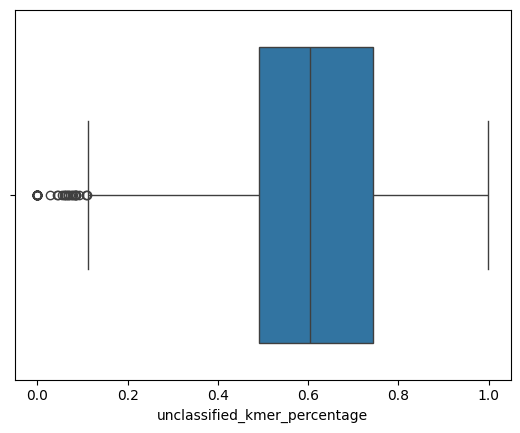

In [80]:
kraken2_predictions["unclassified_kmer_percentage"] = kraken2_predictions["unclassified_kmers"] / (kraken2_predictions["read_length"] - 30)
sns.boxplot(data=kraken2_predictions, orient='h', x="unclassified_kmer_percentage")

In [81]:
np.mean(kraken2_predictions["unclassified_kmer_percentage"])

0.6214902629386245

## Evaluate correctness

In [62]:
# Evaluate correctness
import numpy as np

# Get set of species in GTDB
ground_truth_genus = []
for gt in species_set:
    ground_truth_genus.append(get_level(gt, 'species'))

species_set = set(ground_truth_genus)

species_correct = np.full(len(ground_truth), False, dtype=bool)
genus_correct = np.full(len(ground_truth), False, dtype=bool)
in_db = np.full(len(ground_truth), False, dtype=bool)
prediction_at_species_level = np.full(len(ground_truth), False, dtype=bool)

for i in range(len(ground_truth)):
    if get_level(ground_truth[i], 'species') == get_level(kraken2_predictions["classification_result"][i], 'species'):
        species_correct[i] = True
    if get_level(ground_truth[i]) == get_level(kraken2_predictions["classification_result"][i]):
        genus_correct[i] = True
    if get_level(ground_truth[i], 'species') in species_set:
        in_db[i] = True
    try:
        rank = ncbi.get_rank([kraken2_predictions["classification_result"][i]])
    except:
        rank = None
    if rank is not None and len(rank) != 0:
        #print(rank[kraken2_predictions[i]])
        if rank[kraken2_predictions["classification_result"][i]] in ['species', 'strain']:
            prediction_at_species_level[i] = True

kraken2_predictions["predict_at_genus"] = genus_correct
kraken2_predictions["predict_at_species"] = species_correct
kraken2_predictions["species_in_db"] = in_db
kraken2_predictions["at_species_level"] = prediction_at_species_level

In [63]:
kraken2_predictions

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level
0,C,SRR24651298.1,100886,8663,100886:9 135858:2 100886:3 135858:8 0:28 13585...,100886,3148,2365,5051,True,True,True,True
1,C,SRR24651298.2,100886,2129,0:30 135858:2 100886:1 135858:12 0:25 100886:5...,100886,712,211,1356,True,True,True,True
2,C,SRR24651298.3,100886,3852,135858:37 100886:12 135858:2 100886:6 135858:3...,100886,1818,512,1992,True,True,True,True
3,C,SRR24651298.4,100886,6186,100886:8 135858:12 0:47 100886:23 135858:2 100...,100886,1616,638,4425,True,True,True,True
4,C,SRR24651298.5,100886,790,0:5 135858:4 100886:14 135858:1 100886:3 13585...,100886,355,115,396,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,C,SRR24651270.996,411464,25452,0:1 901:5 0:50 411464:5 901:1 0:3 901:5 0:23 4...,901,12662,11458,11170,True,True,True,True
71996,C,SRR24651270.997,411464,2122,411464:2 0:57 901:53 0:38 411464:5 901:1 41146...,901,541,534,1508,True,True,True,True
71997,C,SRR24651270.998,411464,11199,0:30 2479851:5 0:6 1930279:1 0:9 901:23 0:16 9...,901,2843,2803,7600,True,True,True,True
71998,C,SRR24651270.999,411464,2373,0:156 411464:3 0:20 411464:12 0:57 411464:11 1...,901,129,129,2192,True,True,True,True


### Completely wrong classification

In [69]:
kraken2_predictions[kraken2_predictions["classified"] == True][kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["predict_at_species"] == False]

/tmp/ipykernel_22840/2338805114.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["classified"] == True][kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["predict_at_species"] == False]
/tmp/ipykernel_22840/2338805114.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["classified"] == True][kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["predict_at_species"] == False]


,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level


### Classification at a higher level

In [84]:
kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]

/tmp/ipykernel_22840/3264823123.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3264823123.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3264823123.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]


,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,unclassified_kmer_percentage
50,C,SRR24651298.51,135858,441,2:12 526525:5 135858:34 526525:5 2:10 131567:5...,100886,90,0,122,True,False,True,False,0.296837
278,C,SRR24651298.279,135858,882,2:6 2944914:5 2:1 0:17 135858:22 526525:5 2:10...,100886,31,0,564,True,False,True,False,0.661972
312,C,SRR24651298.313,135858,538,0:27 2:5 0:54 1783272:5 0:28 135858:1 0:384,100886,1,0,493,True,False,True,False,0.970472
493,C,SRR24651298.494,135858,293,0:6 135858:10 526525:5 2:10 131567:5 2:30 1315...,100886,44,0,104,True,False,True,False,0.395437
504,C,SRR24651298.505,135858,680,0:7 1239:33 0:39 1239:1 0:2 1239:7 0:62 1239:1...,100886,68,0,409,True,False,True,False,0.629231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66976,C,SRR24651304.977,816,10703,0:425 815:5 0:56 815:22 976:2 815:5 976:3 2:5 ...,818,347,3,9973,True,False,True,False,0.934414
66991,C,SRR24651304.992,816,1997,0:20 816:4 0:142 816:4 0:23 816:4 0:4 816:26 0...,818,544,0,1414,True,False,True,False,0.718861
67053,C,SRR24651179.54,2719231,469,0:42 2719231:6 0:2 2719231:5 0:5 186801:2 0:4 ...,84030,27,0,383,True,False,True,False,0.872437
69801,C,SRR24651174.802,84111,5586,0:1738 1802376:2 0:649 1852619:5 0:164 2045107...,84112,97,0,5369,True,False,True,False,0.966343


### Wrong Classification at lower level

In [87]:
wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
wrong_at_species_level

/tmp/ipykernel_22840/1484281633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/1484281633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/1484281633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,unclassified_kmer_percentage
412,C,SRR24651298.413,286142,2127,2:1 0:27 1239:2 2:5 0:31 2:21 1239:5 0:1 1239:...,100886,5,0,1513,True,False,True,True,0.721507
1569,C,SRR24651261.570,747375,806,0:1 747375:2 0:65 747375:27 0:483 747375:7 0:6...,102148,58,0,697,True,False,True,True,0.898196
2323,C,SRR24651237.324,876091,7977,0:338 2567896:3 1783272:5 0:1 2801029:5 0:54 8...,1226322,16,0,7814,True,False,True,True,0.983264
2502,C,SRR24651237.503,1855299,199,0:6 1855299:7 186802:7 0:48 1855299:40 0:4 216...,1226322,47,0,105,True,False,True,True,0.621302
2512,C,SRR24651237.513,876091,1108,0:10 216572:6 1855299:1 0:5 1855299:1 0:42 876...,1226322,76,0,908,True,False,True,True,0.842301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66799,C,SRR24651304.800,1236513,2708,2:28 815:7 171549:1 815:5 816:5 0:38 816:3 815...,818,229,0,1350,True,False,True,True,0.504108
66898,C,SRR24651304.899,657309,13896,171549:16 815:5 171549:1 816:5 815:3 816:7 815...,818,8537,62,5220,True,False,True,True,0.376460
66923,C,SRR24651304.924,162156,8842,816:249 0:27 816:42 0:1 816:1 0:20 816:36 0:35...,818,4822,11,3923,True,False,True,True,0.445188
66982,C,SRR24651304.983,657309,1746,0:94 816:2 0:39 816:8 0:119 657309:1 816:16 0:...,818,221,0,1353,True,False,True,True,0.788462


### Wrong classification at genus level

In [93]:
wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
wrong_at_genus_level

/tmp/ipykernel_22840/3259088467.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3259088467.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3259088467.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,unclassified_kmer_percentage
291,C,SRR24651298.292,1123263,7203,0:93 2:7 0:134 135858:2 1239:1 135858:1 1239:2...,100886,372,175,6312,False,False,True,True,0.879967
1218,C,SRR24651261.219,1219626,10588,0:80 1239:8 0:1 1239:3 0:5 1239:3 0:10 1123263...,102148,31,31,7979,False,False,True,True,0.755730
1248,C,SRR24651261.249,316097,5888,1239:9 2069309:2 0:59 1239:9 0:9 1239:5 0:1 12...,102148,0,0,2731,False,False,True,True,0.466200
1295,C,SRR24651261.296,2652274,14574,0:2 1121128:3 0:4 2:20 0:56 2:10 0:89 2:8 0:17...,102148,0,0,8806,False,False,True,True,0.605473
1396,C,SRR24651261.397,759821,5660,0:4 2:26 0:15 2:1 0:9 2:3 0:1 2:1 0:2 2:68 0:3...,102148,0,0,3253,False,False,True,True,0.577798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70275,C,SRR24651300.276,261299,722,0:35 186804:5 0:9 1783272:1 0:14 261299:13 186...,89153,0,0,284,False,False,True,True,0.410405
71206,C,SRR24651270.207,2652274,10246,0:26 2652274:5 0:31 2652274:43 0:113 2652274:3...,901,0,0,6568,False,False,True,True,0.642913
71586,C,SRR24651270.587,2027858,331,2:3 0:1 2:3 0:1 2:3 0:5 2:25 0:33 2:6 0:50 156...,901,0,0,214,False,False,True,True,0.710963
71623,C,SRR24651270.624,1337051,309,2:15 186801:27 2:5 0:47 2:5 0:141 2:3 0:1 2:1 ...,901,0,0,194,False,False,True,True,0.695341


sns.histplot(data=kraken2_predictions, x="read_length", hue="predict_at_genus", log_scale=True,
             stat="density")

<Axes: xlabel='unclassified_kmer_percentage', ylabel='Density'>

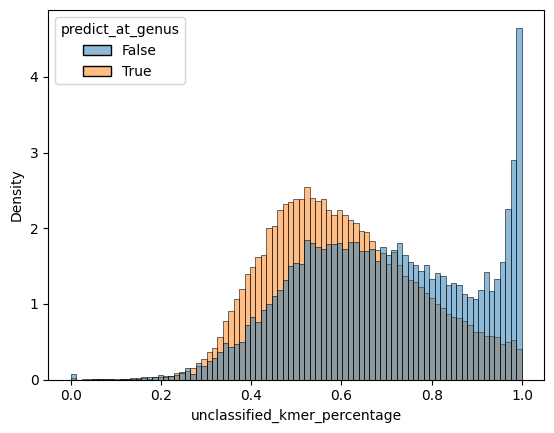

In [111]:
sns.histplot(data=kraken2_predictions, x="unclassified_kmer_percentage", hue="predict_at_genus", common_norm=False,
             stat="density")

<Axes: xlabel='effective_k_mers', ylabel='Density'>

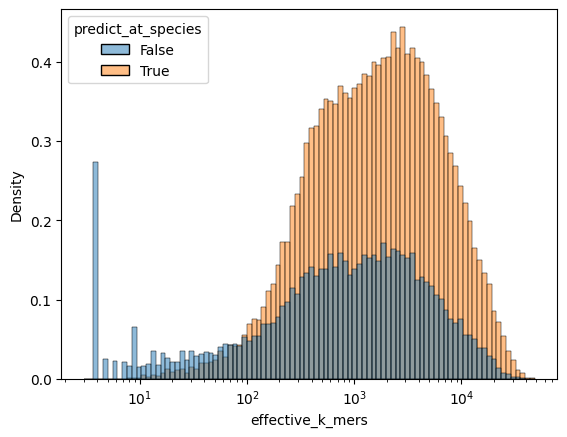

In [119]:
kraken2_predictions["effective_k_mers"] = kraken2_predictions["read_length"] - 30 - kraken2_predictions["unclassified_kmers"]

sns.histplot(data=kraken2_predictions, x="effective_k_mers", hue="predict_at_species", log_scale=True,
             stat="density")

<Axes: xlabel='read_length', ylabel='Density'>

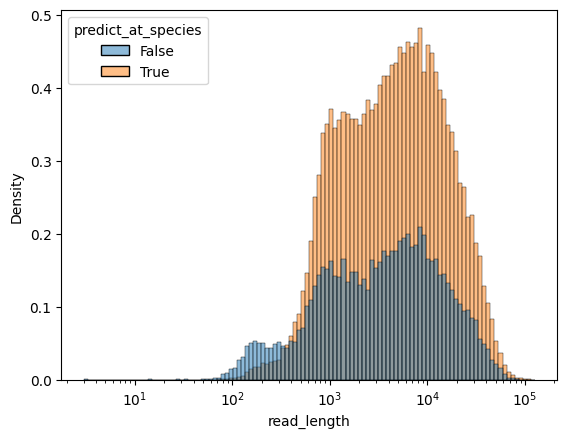

In [120]:
sns.histplot(data=kraken2_predictions, x="read_length", hue="predict_at_species", log_scale=True,
             stat="density")

In [6]:
sum_res = result.groupby('Ground Truth').sum()
for feature in ['species_correct', 'genus_correct', 'in_db', 'prediction_at_species_level']:
    sum_res[feature] /= sum_res['count']

sum_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
817,311940123,0.889,0.9230,1.0,0.9800,1000
818,568103998,0.833,0.9645,1.0,0.9560,2000
901,411009236,0.986,0.9870,1.0,0.9900,1000
1261,1280412914,0.494,0.9740,1.0,0.9905,2000
1358,228843030,0.785,0.9110,1.0,0.9530,1000
...,...,...,...,...,...,...
1232452,1605582687,0.000,0.0400,1.0,0.9780,1000
1232457,2132609851,0.000,0.1790,1.0,0.8980,1000
1297617,1305794943,0.957,0.9570,1.0,0.9920,1000


In [7]:
in_domain_res = sum_res[sum_res["in_db"] >= 1]

in_domain_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
817,311940123,0.889,0.9230,1.0,0.9800,1000
818,568103998,0.833,0.9645,1.0,0.9560,2000
901,411009236,0.986,0.9870,1.0,0.9900,1000
1261,1280412914,0.494,0.9740,1.0,0.9905,2000
1358,228843030,0.785,0.9110,1.0,0.9530,1000
...,...,...,...,...,...,...
1226322,1182891120,0.000,0.0100,1.0,0.6900,1000
1232452,1605582687,0.000,0.0400,1.0,0.9780,1000
1232457,2132609851,0.000,0.1790,1.0,0.8980,1000


In [21]:
in_domain_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
817,311940123,0.889,0.9230,1.0,0.9800,1000
818,568103998,0.833,0.9645,1.0,0.9560,2000
901,411009236,0.986,0.9870,1.0,0.9900,1000
1261,1280412914,0.494,0.9740,1.0,0.9905,2000
1358,228843030,0.785,0.9110,1.0,0.9530,1000
1507,1581573143,0.000,0.0010,1.0,0.9590,1000
1509,39082565,0.910,0.9670,1.0,0.9650,1000
1535,435959301,0.969,0.9870,1.0,0.9840,1000
1680,543296972,0.719,0.9170,1.0,0.9490,1000


In [13]:
result[result["Ground Truth"] == 1507]

,Ground Truth,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
9000,1507,2953240,False,False,True,True,1
9001,1507,1720313,False,False,True,True,1
9002,1507,165186,False,False,True,True,1
9003,1507,1720313,False,False,True,True,1
9004,1507,1720313,False,False,True,True,1
...,...,...,...,...,...,...,...
9995,1507,1720313,False,False,True,True,1
9996,1507,1720313,False,False,True,True,1
9997,1507,106588,False,False,True,True,1
9998,1507,1720313,False,False,True,True,1


In [14]:
ncbi.get_taxid_translator([1507, 1720313])

{1507: 'Clostridium sp. ATCC 29733',
 1720313: 'Bittarella massiliensis (ex Durand et al. 2017)'}

In [8]:
out_domain_res = sum_res[sum_res["in_db"] <= 0]

out_domain_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
2860054,1812151353,0.0,0.908,0.0,0.923,1000


/tmp/ipykernel_778/1629055615.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


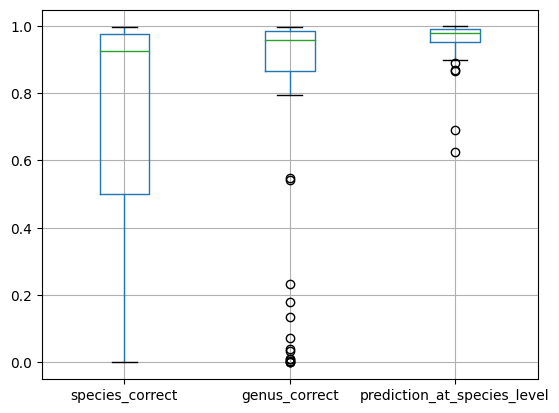

In [12]:
import matplotlib.pyplot as plt

plot = plt.figure()
sum_res.boxplot(column=["species_correct", "genus_correct", "prediction_at_species_level"])
plot.show()
plot.savefig("res.pdf", format='pdf')